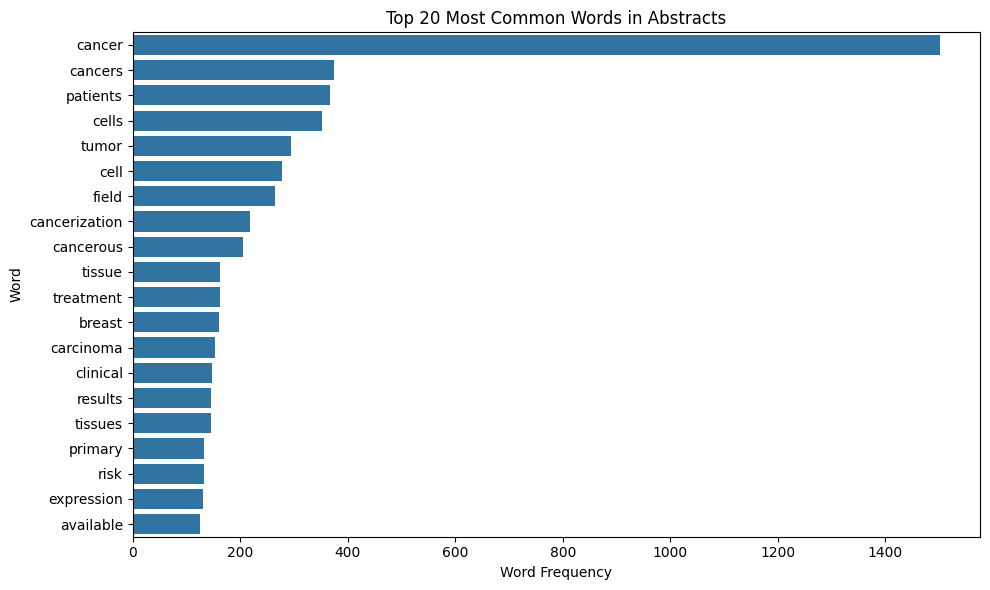

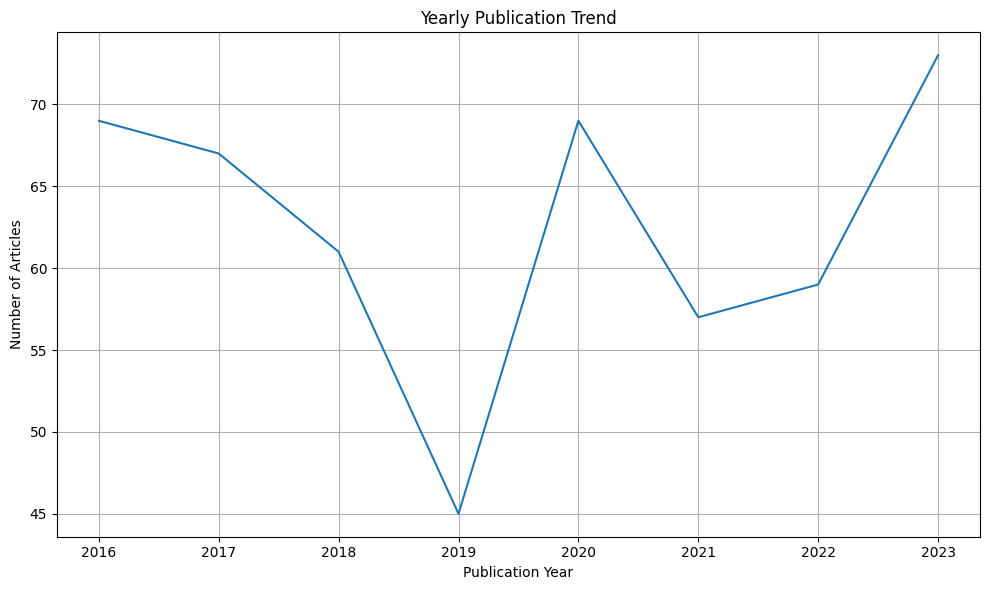

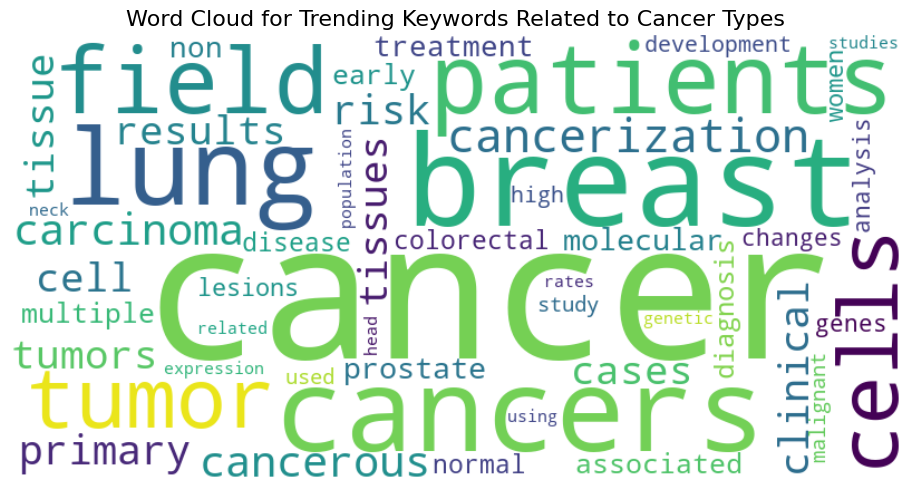

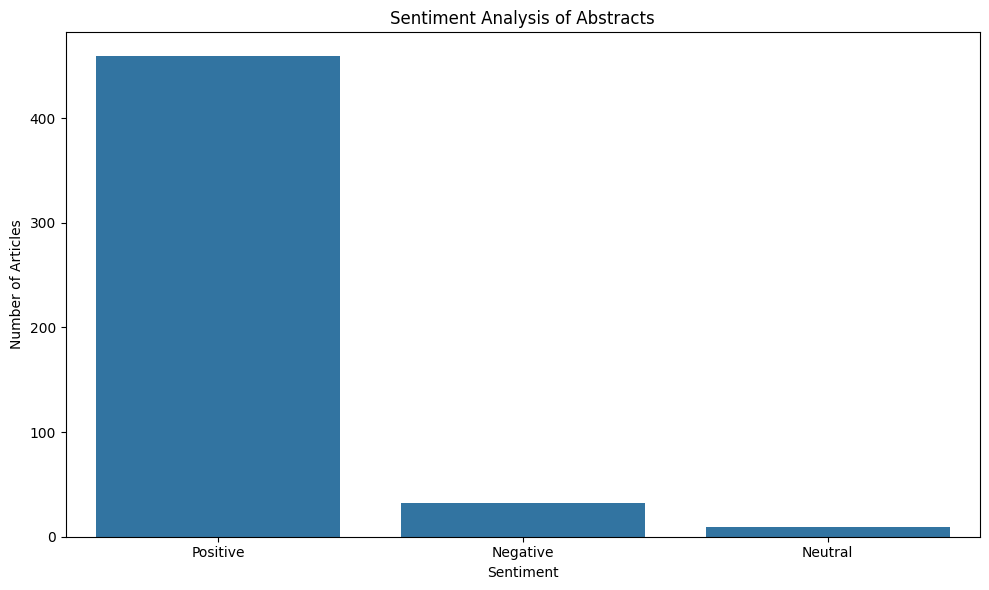

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv('cancer_research_pubmed.csv')  

def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment'] = data['Abstract'].apply(get_sentiment)

data['Abstract'] = data['Abstract'].str.lower()
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(data['Abstract'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
word_freq_df = pd.DataFrame({'Word': words, 'Count': word_counts}).sort_values(by='Count', ascending=False)

class DataVisualizationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Cancer Research Visualization")
        self.root.geometry("1000x800")  
        self.frame = ttk.Frame(root)
        self.frame.pack(pady=20)

        self.chart_type_var = tk.StringVar(value="Distribution of Publication Years")  
        self.chart_dropdown = ttk.Combobox(root, textvariable=self.chart_type_var, values=[
            "Distribution of Publication Years",
            "Top 20 Most Common Words in Abstracts",
            "Top 10 Most Common Authors",
            "Yearly Publication Trend",
            "Word Cloud for Top 20 Words in Abstracts",
            "Word Cloud for Trending Keywords Related to Cancer Types",
            "Sentiment Analysis of Abstracts"
        ])
        self.chart_dropdown.pack(pady=10)

        self.button = ttk.Button(root, text="Show Chart", command=self.show_chart)
        self.button.pack()

    def show_chart(self):
        for widget in self.frame.winfo_children():
            widget.destroy()

        chart_type = self.chart_type_var.get()

        if chart_type == "Distribution of Publication Years":
            self.plot_year_distribution()

        elif chart_type == "Top 20 Most Common Words in Abstracts":
            self.plot_common_words()

        elif chart_type == "Top 10 Most Common Authors":
            self.plot_top_authors()

        elif chart_type == "Yearly Publication Trend":
            self.plot_yearly_trend()

        elif chart_type == "Word Cloud for Top 20 Words in Abstracts":
            self.plot_word_cloud_top_words()

        elif chart_type == "Word Cloud for Trending Keywords Related to Cancer Types":
            self.plot_word_cloud_trending_keywords()

        elif chart_type == "Sentiment Analysis of Abstracts":
            self.plot_sentiment_analysis()

    def plot_year_distribution(self):
        plt.figure(figsize=(10, 6))
        sns.histplot(data['publication'], bins=20, kde=False)
        plt.title('Distribution of Publication Years')
        plt.xlabel('Publication Year')
        plt.ylabel('Number of Articles')
        self._draw_plot()

    def plot_common_words(self):
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Count', y='Word', data=word_freq_df.head(20))
        plt.title('Top 20 Most Common Words in Abstracts')
        plt.xlabel('Word Frequency')
        plt.ylabel('Word')
        self._draw_plot()

    def plot_top_authors(self):
        data_exploded = data.explode('Authors')
        top_authors = data_exploded['Authors'].value_counts().nlargest(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=top_authors.values, y=top_authors.index)
        plt.title('Top 10 Most Common Authors')
        plt.xlabel('Number of Articles')
        plt.ylabel('Author')
        self._draw_plot()

    def plot_yearly_trend(self):
        yearly_trend = data.groupby('publication').size()
        plt.figure(figsize=(10, 6))
        yearly_trend.plot(kind='line')
        plt.title('Yearly Publication Trend')
        plt.xlabel('Publication Year')
        plt.ylabel('Number of Articles')
        plt.grid(True)
        self._draw_plot()

    def plot_word_cloud_top_words(self):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(words, word_counts)))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Top 20 Words in Abstracts', fontsize=16)
        self._draw_plot()

    def plot_word_cloud_trending_keywords(self):
        filtered_data = data[data['Abstract'].str.contains('|'.join(['breast', 'lung', 'colon', 'prostate', 'leukemia']), case=False, na=False)]
        vectorizer = CountVectorizer(stop_words='english', max_features=50)
        tfidf_matrix = vectorizer.fit_transform(filtered_data['Abstract'])
        keyword_scores = tfidf_matrix.sum(axis=0).A1
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(vectorizer.get_feature_names_out(), keyword_scores)))
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Trending Keywords Related to Cancer Types', fontsize=16)
        self._draw_plot()

    def plot_sentiment_analysis(self):
        sentiment_counts = data['Sentiment'].value_counts()
        plt.figure(figsize=(10, 6))
        sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
        plt.title('Sentiment Analysis of Abstracts')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Articles')
        self._draw_plot()

    def _draw_plot(self):
        """Helper function to draw the plot in the Tkinter frame."""
        plt.tight_layout()
        canvas = FigureCanvasTkAgg(plt.gcf(), master=self.frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

if __name__ == "__main__":
    root = tk.Tk()
    app = DataVisualizationApp(root)
    root.mainloop()
